In [ ]:
# Connecting to google drive
from google.colab import files, drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#importing important libraries
import matplotlib.pyplot as plt
import numpy             as np
import pandas            as pd
import seaborn           as sns
import os
import cv2
from google.colab.patches import cv2_imshow
from scipy.ndimage.interpolation import rotate
from random import randint




#Pytorch import
import torch
from torch.nn.parameter import Parameter
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init
from torch.nn.modules.batchnorm import BatchNorm2d

import math
import numpy as np
import matplotlib.pyplot as plt

from tensorflow               import keras     
from torchvision              import models   
from torchsummary            import summary 
from tensorflow.keras.utils   import load_img, img_to_array
from torch.nn                 import Linear, Conv2d, BatchNorm2d, MaxPool2d, Dropout2d, LogSoftmax, ReLU
from skimage                  import color, io
from torch.nn.functional      import relu, elu, relu6, sigmoid, tanh, softmax
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [ ]:
# Load the cascade from OpenCV face classifier
face_cascade = cv2.CascadeClassifier('/content/gdrive/MyDrive/DL Project/OpenCV/haarcascades/haarcascade_frontalface_default.xml')

In [ ]:
#Network structure
no_of_classes = 7

from torch.nn.modules.batchnorm import BatchNorm2d
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.conv1     = nn.Conv2d(in_channels = 1,   out_channels = 64,  kernel_size = 3, padding = 'same')
        self.conv2     = nn.Conv2d(in_channels = 64,  out_channels = 128, kernel_size = 5, padding = 'same')
        self.conv3     = nn.Conv2d(in_channels = 128, out_channels = 512, kernel_size = 3, padding = 'same')
        self.conv4     = nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size = 3, padding = 'same')
        self.batch2d_1 = nn.BatchNorm2d(64)
        self.batch2d_2 = nn.BatchNorm2d(128)
        self.batch2d_3 = nn.BatchNorm2d(512)

        self.batch2d_4 = nn.BatchNorm1d(256)
        self.batch2d_5 = nn.BatchNorm1d(512)
        self.pool      = nn.MaxPool2d(kernel_size = 2)
        self.dropout   = nn.Dropout(0.10)
        self.flatten   = nn.Flatten()

        self.relu     = nn.ReLU()
        self.FC1      = nn.Linear(4608, 256)
        self.log_softmax  = nn.LogSoftmax(dim = 1)
        self.FC2      = nn.Linear(256, 512)
        self.FC3      = nn.Linear(512, 7)
    

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool(x)
        x = self.batch2d_1(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.conv2(x)
        x = self.pool(x)
        x = self.batch2d_2(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.conv3(x)
        x = self.pool(x)
        x = self.batch2d_3(x)
        x = F.relu(x)
        x = self.dropout(x) 

        x = self.conv4(x)
        x = self.pool(x)
        x = self.batch2d_3(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.flatten(x)
        x = self.FC1(x)
        x = self.batch2d_4(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.FC2(x)
        x = self.batch2d_5(x)
        x = F.relu(x)
        x = self.dropout(x)
                        
        x = self.FC3(x)
        x = self.log_softmax(x)
        
        return x



nett = NeuralNetwork()
nett.load_state_dict(torch.load('/content/gdrive/MyDrive/DL Project/bestnet.pth', map_location='cpu'))
nett.eval()
summary(nett, (1,48,48))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 48, 48]             640
         MaxPool2d-2           [-1, 64, 24, 24]               0
       BatchNorm2d-3           [-1, 64, 24, 24]             128
              ReLU-4           [-1, 64, 24, 24]               0
           Dropout-5           [-1, 64, 24, 24]               0
            Conv2d-6          [-1, 128, 24, 24]         204,928
         MaxPool2d-7          [-1, 128, 12, 12]               0
       BatchNorm2d-8          [-1, 128, 12, 12]             256
              ReLU-9          [-1, 128, 12, 12]               0
          Dropout-10          [-1, 128, 12, 12]               0
           Conv2d-11          [-1, 512, 12, 12]         590,336
        MaxPool2d-12            [-1, 512, 6, 6]               0
      BatchNorm2d-13            [-1, 512, 6, 6]           1,024
             ReLU-14            [-1, 51

In [ ]:
#Defining functions
def loadData(dir_path, target, printProgress = True, earlyBreak = 0):
    newArr = []
    if printProgress:
        print('Files in :')
        
    for t in target:
        dir_pathTemp = dir_path + t
    
        temp = []
        for j, i in enumerate(os.listdir(dir_pathTemp)):
            if i.endswith('.jpg'):
                temp.append(io.imread(dir_pathTemp + "/" + i))
                if (earlyBreak != 0 and earlyBreak == j):
                    break
            count = j
      
        if printProgress:
            print('File count in',t,':', count)

        for tmp in temp:
            newArr.append([tmp, np.where(target == t)[0][0]])

    return np.asarray(newArr)
  
def correctFormat(arr):
  newArr = []
  for i, x in enumerate(arr):
      newArr.append(np.expand_dims(x, axis = 0).astype('float32'))
  return np.asarray(newArr)


In [ ]:
#Loading data in correct format
expression = np.array(['angry', 'happy', 'surprise', 'disgust', 'neutral', 'fear', 'sad'])
arr        = loadData("/content/gdrive/MyDrive/DL Project/images/images/train/", expression, earlyBreak = 2)
arr = correctFormat(arr[:,0])

Files in :
File count in angry : 1
File count in happy : 1
File count in surprise : 1
File count in disgust : 1
File count in neutral : 1
File count in fear : 1
File count in sad : 1


<ipython-input-6-a23aec04cdfd>:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.asarray(newArr)


In [ ]:
dir = '/content/gdrive/MyDrive/DL Project/OpenCV/Group2a/'
img  = []

for i, image in enumerate(os.listdir(dir)):
  if i == 10:
    break
  img.append(cv2.imread(dir + image))
 

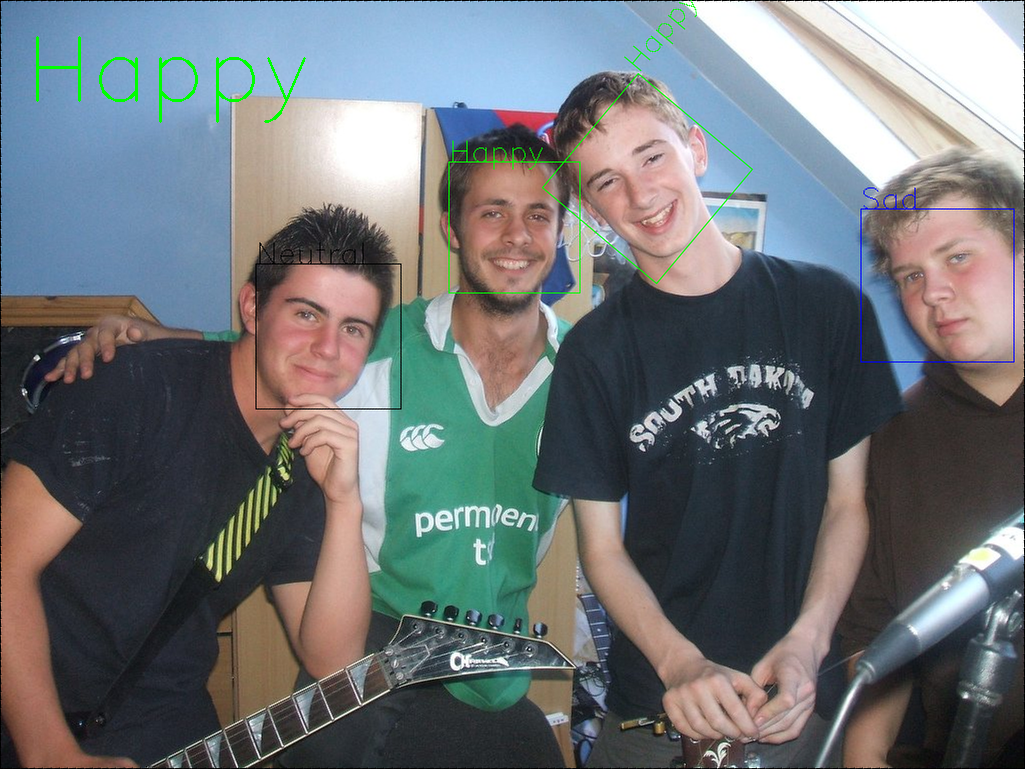

In [ ]:
#Defining the combining function
def moodColor(mood):
  if mood == "Angry":
    return (0,0,255)
  elif mood == "Happy":
    return (0,255,0)
  elif mood == "Surprise":
    return (50,255,50)
  elif mood == "Disgust":
    return (255,0,255)
  elif mood == "Neutral":
    return (0,0,0)
  elif mood == "Fear":
    return (255,255,0)
  elif mood == "Sad":
    return (255,0,0)
  
def moodInTheRoom(img):
  prediction, f = [], []
  m = 0
  CNT = 0

  mood = np.array(['Angry', 'Happy', 'Surprise', 'Disgust', 'Neutral', 'Fear', 'Sad'])
  #mood_score = moodScore(img) 
  imDim = img.shape

  # Ingen rotation
  gray  = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  faces = face_cascade.detectMultiScale(gray, scaleFactor = 1.12, minNeighbors = 5)

  # Roteret 50 grader mod højre
  img50   = rotate(img, angle = 50)
  gray50  = cv2.cvtColor(img50, cv2.COLOR_BGR2GRAY)
  faces50 = face_cascade.detectMultiScale(gray50, scaleFactor = 1.3, maxSize = (200,200), minNeighbors = 5)

  # Roteret 50 grader mod venstre
  img310   = rotate(img, angle = 310)
  gray310  = cv2.cvtColor(img310, cv2.COLOR_BGR2GRAY)
  faces310 = face_cascade.detectMultiScale(gray310, scaleFactor = 1.3, maxSize = (200,200), minNeighbors = 5)


  # Tilføjer alle ansigter til en liste af lister, hvor der opdeles for hvert billede, 
  # og tegner firkanter omkring de fundne ansigter på det oprindelige billede.
  for i, (x, y, w, h) in enumerate(faces):
    f.append(cv2.resize(img[y : y + h, x : x + w], dsize = (48, 48)))
    face = f[i]
    face = color.rgb2gray(face) * 255
    face = np.expand_dims(face, axis = 0).astype('float32')
    face = np.expand_dims(face, axis = 0).astype('float32')
    face = torch.from_numpy(face)
    output = nett(face)
    m += output
    prediction.append(torch.max(output,  1)[1])
    cv2.rectangle(img, (x, y), (x + w, y + h), moodColor(mood[prediction[i]]), 1)
    img = cv2.putText(img = img, text = mood[prediction[i]], org = (x, y), fontFace = cv2.FONT_HERSHEY_SIMPLEX, 
                      fontScale = 1, color = moodColor(mood[prediction[i]]), thickness = 1)
    CNT += 1

  if np.any(faces50):
    img = rotate(img, 50)
    for i, (x, y, w, h) in enumerate(faces50):
      f.append(cv2.resize(img50[y : y + h, x : x + w], dsize = (48, 48)))
      face = f[i + CNT]
      face = color.rgb2gray(face) * 255
      face = np.expand_dims(face, axis = 0).astype('float32')
      face = np.expand_dims(face, axis = 0).astype('float32')
      face = torch.from_numpy(face)
      output = nett(face)
      m += output
      prediction.append(torch.max(output,  1)[1])
      cv2.rectangle(img, (x, y), (x + w, y + h), moodColor(mood[prediction[i + CNT]]), 1)
      img = cv2.putText(img = img, text = moodRoom, org = (x, y), fontFace = cv2.FONT_HERSHEY_SIMPLEX, 
                      fontScale = 1, color = moodColor(prediction[i]), thickness = 2)
      CNT += 1
    img = rotate(img, 310)

  if np.any(faces310):
    img = rotate(img, 310)
    for i, (x, y, w, h) in enumerate(faces310):
      f.append(cv2.resize(img310[y : y + h, x : x + w], dsize = (48, 48)))
      face = f[i + CNT]
      face = color.rgb2gray(face) * 255
      face = np.expand_dims(face, axis = 0).astype('float32')
      face = np.expand_dims(face, axis = 0).astype('float32')
      face = torch.from_numpy(face)
      output = nett(face)
      m += output
      prediction.append(torch.max(output,  1)[1])
      cv2.rectangle(img, (x, y), (x + w, y + h), moodColor(mood[prediction[i + CNT]]), 1)
      img = cv2.putText(img = img, text = mood[prediction[i]], org = (x + w, y), fontFace = cv2.FONT_HERSHEY_SIMPLEX, 
                        fontScale = 1, color = moodColor(mood[prediction[i]]), thickness = 1)
      CNT += 1
    img = rotate(img, 50)

  # Fjerner black bars
  xAxis = int((img.shape[0] - imDim[0]) / 2)
  yAxis = int((img.shape[1] - imDim[1]) / 2)
  f.insert(0, img[xAxis : img.shape[0] - xAxis, yAxis : img.shape[1] - yAxis])

  moodRoom = mood[torch.max(m / CNT, 1)[1]]

  image = cv2.putText(img = f[0], text = moodRoom, org = (25, 100), fontFace = cv2.FONT_HERSHEY_SIMPLEX, 
                      fontScale = 3, color = moodColor(moodRoom), thickness = 2)
  cv2_imshow(image)
 

moodInTheRoom(img[1])